In [1]:
# data modules
import numpy as np
import scipy.stats as stats
import pandas as pd

# plotting modules
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Stats/Regresions Packages
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# make sure charts appear in the notebook:
%matplotlib inline
%config InlineBackend.figure_format ='retina'


from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

import os
import datetime
from scipy.stats import mode


path='/Users/joaquincunanan/Dropbox/OKC/okc_user_data.csv'
okc=pd.read_csv(path)

/anaconda/envs/dsi2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,139,140,141,142,143,144,145,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,25

In [2]:
okc.head()

,Unnamed: 0,q2,q11,q12,q13,q14,q16,q17,q18,q20,...,q86210,q86215,q86283,q86325,q86364,q86397,q86462,q86615,q86699,q363047
0,---Rosie---,NaN,Horrified,NaN,NaN,NaN,NaN,No,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,--Him--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,--kaleidoscope--,NaN,NaN,NaN,No,No,NaN,No,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,--Lucy--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,--stars,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [396]:
okc.shape

(68371, 2621)

In [398]:
# okc_x=okc
# okc_x['count']=
okc.groupby(['Unnamed: 0']).count()

,q2,q11,q12,q13,q14,q16,q17,q18,q20,q22,...,q86210,q86215,q86283,q86325,q86364,q86397,q86462,q86615,q86699,q363047
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
---KELLY--,1,1,0,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
---Rosie---,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
--Him--,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
--Jordan--,1,1,1,1,1,0,1,0,1,1,...,0,0,0,0,0,0,0,1,0,0
--Lucy--,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
--Tek--,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1
--kaleidoscope--,0,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
--michael-,0,1,1,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
--stars,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [400]:
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
x=okc.sum(axis=1)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
x

Timestamp: 2017-08-08 22:47:08
Timestamp: 2017-08-08 22:49:22


0        89818.0
1           64.0
2        89994.0
3          306.0
4        89690.0
5        89580.0
6        89638.0
7           82.0
8           78.0
9          101.0
10       89603.0
11          85.0
12       90054.0
13          32.0
14       89868.0
15         117.0
16       98547.0
17          64.0
18       89906.0
19       89539.0
20          61.0
21         -40.0
22       98796.0
23       89500.0
24          77.0
25       90018.0
26       89864.0
27          14.0
28       89994.0
29       89645.0
          ...   
68341      -59.0
68342      -39.0
68343      304.0
68344      -91.0
68345       61.0
68346     -218.0
68347     -426.0
68348      275.0
68349     -292.0
68350      437.0
68351      344.0
68352     -116.0
68353     -185.0
68354     -205.0
68355     -385.0
68356      208.0
68357       24.0
68358      188.0
68359      344.0
68360      439.0
68361      478.0
68362      305.0
68363     -208.0
68364     -159.0
68365      285.0
68366      281.0
68367      307.0
68368      104

In [401]:
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
x=okc.count(axis=1)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
x

Timestamp: 2017-08-08 22:51:34
Timestamp: 2017-08-08 22:51:48


0        300
1         24
2        418
3         44
4        104
5        393
6        256
7         76
8         43
9         56
10       410
11        26
12       800
13        57
14       276
15        85
16       108
17        27
18       132
19        66
20        36
21       139
22       213
23       196
24        28
25       606
26       110
27        48
28       235
29       154
        ... 
68341     51
68342     63
68343     56
68344     48
68345     46
68346     54
68347     55
68348     59
68349     52
68350     52
68351     59
68352     49
68353     58
68354     47
68355     61
68356     48
68357     50
68358     51
68359     52
68360     47
68361     49
68362     47
68363     53
68364     57
68365     48
68366     49
68367     52
68368     44
68369     50
68370     48
Length: 68371, dtype: int64

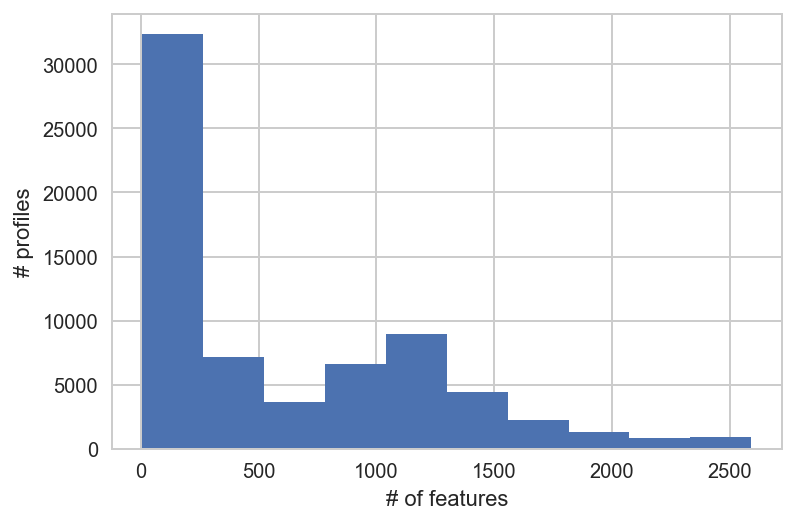

In [407]:

plt.hist(x)
plt.ylabel('# profiles')
plt.xlabel('# of features')

In [3]:
y=okc.columns
for k in y:
    if k[0]<>'q':
        print(k)

Unnamed: 0
p_conf
d_astrology_seriosity
p_laidback
d_education_phase
p_drug
d_gender
p_lit
p_progress
d_income
p_roman
p_dominant
d_religion_type
d_drugs
p_polit
p_pure
lf_want
d_smokes
p_manners
p_submissive
p_inde
p_kinky
p_opti
p_sloppy
p_indie
p_introvert
d_astrology_sign
d_country
p_arro
p_ambi
d_drinks
p_cool
p_trusting
d_age
p_thrift
d_ethnicity
p_organ
p_sexdrive
d_offspring_current
d_bodytype
p_honest
lf_max_age
lf_for
p_expsex
p_artsy
p_scien
d_job
d_orientation
d_username
d_languages
p_spon
p_explife
d_relationship
d_offspring_desires
p_greed
p_capi
p_giving
p_explove
lf_location
p_convenmoral
p_aggre
p_kind
p_extro
p_friendstrangers
p_oldfash
p_comp
p_lovedri
p_sprit
lf_min_age
p_passion
d_city
d_education_type
p_energetic
p_exer
p_logic
lf_single
p_math
d_religion_seriosity
p_geeky
p_adven


In [5]:
path='/Users/joaquincunanan/Dropbox/OKC/user_data_public.csv'
okc2=pd.read_csv(path)

In [6]:
okc2.head()

,q2,q11,q12,q13,q14,q16,q17,q18,q20,q22,...,q86615,q86699,q363047,CA,gender_orientation,gender,race,gender2,gender2_num,CA_items
0,NaN,Horrified,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,...,NaN,NaN,NaN,0.763080,Hetero_female,Woman,White,Woman,0.0,4.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Hetero_male,Man,NaN,Man,1.0,0.0
2,NaN,NaN,NaN,No,No,NaN,No,NaN,NaN,NaN,...,NaN,NaN,NaN,0.661309,Hetero_female,Woman,NaN,Woman,0.0,7.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Hetero_female,Woman,White,Woman,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.875424,Bisexual_female,Woman,NaN,Woman,0.0,3.0


In [395]:
okc2.shape

(24777, 2625)

In [7]:
okc2=okc2[okc2.gender_orientation.isin(['Hetero_female','Bisexual_female'])]

In [8]:
x=okc2.T


In [9]:
x.head()

,0,2,3,4,8,10,12,13,15,17,...,68339,68342,68345,68350,68352,68353,68358,68362,68367,68369
q2,NaN,NaN,NaN,NaN,NaN,more pathetic than cool,more pathetic than cool,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
q11,Horrified,NaN,NaN,NaN,NaN,Horrified,Aroused,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
q12,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
q13,NaN,No,NaN,NaN,NaN,No,No,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
q14,NaN,No,NaN,NaN,NaN,No,No,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [409]:
questions.head(20)


,q,text,option_1,option_2,option_3,option_4,N,Type,Order,Keywords,flag
0,q2,Breast implants?,more cool than pathetic,more pathetic than cool,NaN,NaN,24839,N,NaN,sex/intimacy; preference; opinion,0
1,q11,How does the idea of being slapped hard in the...,Horrified,Aroused,Nostalgic,Indifferent,28860,N,NaN,sex/intimacy,0
2,q12,Divide your age by 2. Have you had sex with a...,Yes,No,NaN,NaN,22496,O,NaN,sex/intimacy,0
3,q13,Is a girl who's slept with 100 guys a bad person?,Yes,No,NaN,NaN,32581,O,NaN,sex/intimacy,0
4,q14,Is a guy who's slept with 100 girls a bad person?,Yes,No,NaN,NaN,31127,O,NaN,sex/intimacy,0
5,q16,Should sex with someone 16 years old be a jail...,Yes,No,NaN,NaN,8341,O,NaN,sex/intimacy,0
6,q17,Would you date someone just for the sex?,Yes,No,NaN,NaN,38180,O,NaN,sex/intimacy,0
7,q18,Do you have experience being in a slave/master...,Yes,No,NaN,NaN,21686,O,NaN,sex/intimacy; BDSM,0
8,q20,"BDSM: Without looking it up, do you know exact...",Yes,No,NaN,NaN,16643,O,NaN,sex/intimacy; BDSM,0
9,q21,Do you enjoy meaningless sex?,Yes,No,NaN,NaN,31024,O,NaN,sex/intimacy,0


[nan nan nan ..., 'Woman' 0.0 7.0]
[nan nan nan ..., 'Woman' 0.0 0.0]
[nan nan nan ..., 'Woman' 0.0 3.0]
[nan nan nan ..., 'Woman' 0.0 0.0]
['more pathetic than cool' 'Horrified' 'No' ..., 'Woman' 0.0 3.0]
['more pathetic than cool' 'Aroused' nan ..., 'Woman' 0.0 7.0]
[nan nan nan ..., 'Woman' 0.0 1.0]
[nan nan nan ..., 'Woman' 0.0 1.0]
[nan nan nan ..., 'Woman' 0.0 0.0]
[nan nan nan ..., 'Woman' 0.0 3.0]
[nan nan nan ..., 'Woman' 0.0 0.0]
[nan nan nan ..., 'Woman' 0.0 4.0]
[nan nan nan ..., 'Woman' 0.0 6.0]
[nan nan nan ..., 'Woman' 0.0 0.0]
[nan nan nan ..., 'Woman' 0.0 2.0]
[nan nan nan ..., 'Woman' 0.0 0.0]
[nan nan nan ..., 'Woman' 0.0 1.0]
[nan nan nan ..., 'Woman' 0.0 4.0]
[nan nan nan ..., 'Woman' 0.0 1.0]
[nan 'Indifferent' nan ..., 'Woman' 0.0 6.0]
[nan nan nan ..., 'Woman' 0.0 4.0]
[nan nan nan ..., 'Woman' 0.0 4.0]
[nan nan nan ..., 'Woman' 0.0 3.0]
['more pathetic than cool' 'Aroused' 'Yes' ..., 'Woman' 0.0 9.0]
[nan nan nan ..., 'Woman' 0.0 0.0]
[nan nan nan ..., 'Woman' 

In [14]:
okc2.iloc[:,5].value_counts()

Yes    1546
No      447
Name: q16, dtype: int64

In [15]:
okc2.describe(include='all')

,q2,q11,q12,q13,q14,q16,q17,q18,q20,q22,...,q86615,q86699,q363047,CA,gender_orientation,gender,race,gender2,gender2_num,CA_items
count,7063,7988,6087,9972,9440,1993,12182,5917,4374,4824,...,2541,1339,1153,19615.000000,24777,24777,20429,24777,24777.0,24777.000000
unique,2,4,2,2,2,2,2,2,2,2,...,4,4,2,NaN,2,1,10,1,NaN,NaN
top,more pathetic than cool,Horrified,No,No,No,Yes,No,No,Yes,Yes,...,No.,"Yes, but only if certain criteria are met.",No,NaN,Hetero_female,Woman,White,Woman,NaN,NaN
freq,5686,4943,3666,8795,8154,1546,8674,5063,3725,2756,...,1470,532,669,NaN,20984,24777,14137,24777,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.059712,NaN,NaN,NaN,NaN,0.0,3.177907
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.990994,NaN,NaN,NaN,NaN,0.0,2.895666
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-4.250054,NaN,NaN,NaN,NaN,0.0,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.731470,NaN,NaN,NaN,NaN,0.0,1.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.018510,NaN,NaN,NaN,NaN,0.0,3.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.708136,NaN,NaN,NaN,NaN,0.0,5.000000


In [16]:
okc2.shape

(24777, 2625)

In [17]:
okc2.groupby('gender_orientation').count()

,q2,q11,q12,q13,q14,q16,q17,q18,q20,q22,...,q86462,q86615,q86699,q363047,CA,gender,race,gender2,gender2_num,CA_items
gender_orientation,,,,,,,,,,,,,,,,,,,,,
Bisexual_female,1199,1663,1308,2118,1934,452,2277,1160,996,963,...,188,499,243,568,3260,3793,3218,3793,3793,3793
Hetero_female,5864,6325,4779,7854,7506,1541,9905,4757,3378,3861,...,795,2042,1096,585,16355,20984,17211,20984,20984,20984


In [18]:
x=okc2.groupby('gender').count()

In [19]:
x=x.reset_index()

In [20]:
x2=x.T

In [21]:
x3=x2.reset_index()

In [22]:
x3.head(525)

,index,0
0,gender,Woman
1,q2,7063
2,q11,7988
3,q12,6087
4,q13,9972
5,q14,9440
6,q16,1993
7,q17,12182
8,q18,5917
9,q20,4374


In [47]:
x3=x2.sort_values([0],ascending=False)
x3.drop(x3.index[[0]],inplace=True)
x4=x3.head(250)

In [48]:
x4.index

Index([u'q34113', u'q85419', u'q416235', u'd_gender', u'lf_want', u'd_country',
       u'd_age', u'lf_max_age', u'lf_for', u'd_orientation',
       ...
       u'q48953', u'q46856', u'q15752', u'q67641', u'q23293', u'q21527',
       u'q105', u'q1112', u'q53965', u'q32'],
      dtype='object', length=250)

In [49]:
okc2[x4.index]

,q34113,q85419,q416235,d_gender,lf_want,d_country,d_age,lf_max_age,lf_for,d_orientation,...,q48953,q46856,q15752,q67641,q23293,q21527,q105,q1112,q53965,q32
0,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,UK,25.0,36.0,For long-term dating,Straight,...,0,0,Extremely important,Very important.,0,No,No,Yes,Catch it and put it outside.,I have little or no interest.
2,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,Australia,22.0,40.0,"For new friends, long-term dating",Straight,...,0,Complex,Not at all important,0,Wholesome,0,No,0,Find someone else to deal with it.,I have little or no interest.
3,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,UK,29.0,38.0,"For new friends, long-term dating, short-term...",Straight,...,0,0,0,0,0,0,0,0,0,0
4,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Everyone,UK,30.0,46.0,"For new friends, long-term dating, short-term...",Bisexual,...,0,0,0,0,0,0,0,0,0,0
8,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men,Netherlands,24.0,30.0,"For new friends, short-term dating",Straight,...,0,0,0,0,0,0,0,0,0,0
10,"It's okay, if it is not abused","Red (such as Merlot, Cabernet, Shiraz).",Yes,Woman,Men who like women,Australia,25.0,30.0,"For new friends, long-term dating, short-term...",Straight,...,Historically or culturally important places.,Complex,Extremely important,0,Crazy and colorful,No,0,0,0,I have little or no interest.
12,No problem,"White (such as Chardonnay, Riesling).",Yes,Woman,Everyone,Netherlands,28.0,38.0,For new friends,Bisexual,...,Historically or culturally important places.,Complex,Very important,Somewhat important.,Wholesome,No,No,Yes,Catch it and put it outside.,I have tried it.
13,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,Germany,24.0,34.0,"For long-term dating, short-term dating",Straight,...,0,0,0,0,0,0,0,0,0,0
15,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Everyone,UK,21.0,28.0,"For new friends, long-term dating, short-term...",Bisexual,...,0,0,0,0,0,0,0,0,0,0
17,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men,UK,20.0,26.0,"For new friends, long-term dating, short-term...",Straight,...,0,0,0,0,0,0,0,0,0,0


In [26]:
path='/Users/joaquincunanan/Dropbox/OKC/question_data.csv'
questions=pd.read_csv(path,delimiter=';')

In [27]:
questions.head()

,Unnamed: 0,text,option_1,option_2,option_3,option_4,N,Type,Order,Keywords
0,q2,Breast implants?,more cool than pathetic,more pathetic than cool,NaN,NaN,24839,N,NaN,sex/intimacy; preference; opinion
1,q11,How does the idea of being slapped hard in the...,Horrified,Aroused,Nostalgic,Indifferent,28860,N,NaN,sex/intimacy
2,q12,Divide your age by 2. Have you had sex with a...,Yes,No,NaN,NaN,22496,O,NaN,sex/intimacy
3,q13,Is a girl who's slept with 100 guys a bad person?,Yes,No,NaN,NaN,32581,O,NaN,sex/intimacy
4,q14,Is a guy who's slept with 100 girls a bad person?,Yes,No,NaN,NaN,31127,O,NaN,sex/intimacy


In [28]:
questions.rename(index=str,columns={"Unnamed: 0":"q"},inplace=True)
#df.rename(index=str, columns={"A": "a", "B": "c"})
questions.head()

,q,text,option_1,option_2,option_3,option_4,N,Type,Order,Keywords
0,q2,Breast implants?,more cool than pathetic,more pathetic than cool,NaN,NaN,24839,N,NaN,sex/intimacy; preference; opinion
1,q11,How does the idea of being slapped hard in the...,Horrified,Aroused,Nostalgic,Indifferent,28860,N,NaN,sex/intimacy
2,q12,Divide your age by 2. Have you had sex with a...,Yes,No,NaN,NaN,22496,O,NaN,sex/intimacy
3,q13,Is a girl who's slept with 100 guys a bad person?,Yes,No,NaN,NaN,32581,O,NaN,sex/intimacy
4,q14,Is a guy who's slept with 100 girls a bad person?,Yes,No,NaN,NaN,31127,O,NaN,sex/intimacy


In [29]:
import re
questions['flag']=questions.q.apply(lambda x: 1 if re.search('p_',x) else 0)
questions.head()

,q,text,option_1,option_2,option_3,option_4,N,Type,Order,Keywords,flag
0,q2,Breast implants?,more cool than pathetic,more pathetic than cool,NaN,NaN,24839,N,NaN,sex/intimacy; preference; opinion,0
1,q11,How does the idea of being slapped hard in the...,Horrified,Aroused,Nostalgic,Indifferent,28860,N,NaN,sex/intimacy,0
2,q12,Divide your age by 2. Have you had sex with a...,Yes,No,NaN,NaN,22496,O,NaN,sex/intimacy,0
3,q13,Is a girl who's slept with 100 guys a bad person?,Yes,No,NaN,NaN,32581,O,NaN,sex/intimacy,0
4,q14,Is a guy who's slept with 100 girls a bad person?,Yes,No,NaN,NaN,31127,O,NaN,sex/intimacy,0


In [20]:
questions[questions.flag==1]

,q,text,option_1,option_2,option_3,option_4,N,Type,Order,Keywords,flag
2541,p_conf,Confident,NaN,NaN,NaN,NaN,12103,NaN,NaN,NaN,1
2542,p_laidback,Laid-back,NaN,NaN,NaN,NaN,6306,NaN,NaN,NaN,1
2543,p_drug,Drug-friendly,NaN,NaN,NaN,NaN,4481,NaN,NaN,NaN,1
2544,p_lit,Literary,NaN,NaN,NaN,NaN,25304,NaN,NaN,NaN,1
2545,p_progress,Progressive,NaN,NaN,NaN,NaN,2200,NaN,NaN,NaN,1
2546,p_roman,Romantic,NaN,NaN,NaN,NaN,22509,NaN,NaN,NaN,1
2547,p_dominant,Dominant,NaN,NaN,NaN,NaN,8733,NaN,NaN,NaN,1
2548,p_polit,Political,NaN,NaN,NaN,NaN,25375,NaN,NaN,NaN,1
2549,p_pure,Pure,NaN,NaN,NaN,NaN,29816,NaN,NaN,NaN,1
2550,p_manners,Manners,NaN,NaN,NaN,NaN,14489,NaN,NaN,NaN,1


In [21]:
p_questions=questions[questions.flag==1].q

In [22]:
okc2[p_questions].head()

,p_conf,p_laidback,p_drug,p_lit,p_progress,p_roman,p_dominant,p_polit,p_pure,p_manners,...,p_comp,p_lovedri,p_sprit,p_passion,p_energetic,p_exer,p_logic,p_math,p_geeky,p_adven
0,NaN,NaN,NaN,67.0,NaN,NaN,NaN,11.0,NaN,NaN,...,NaN,NaN,NaN,90.0,NaN,NaN,NaN,35.0,NaN,NaN
2,NaN,NaN,NaN,62.0,NaN,4.0,NaN,22.0,NaN,83.0,...,35.0,39.0,40.0,32.0,NaN,NaN,NaN,NaN,-34.0,NaN
3,NaN,NaN,NaN,7.0,NaN,-57.0,NaN,45.0,NaN,NaN,...,NaN,NaN,-22.0,NaN,NaN,NaN,NaN,39.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.0,NaN,...,NaN,NaN,-18.0,NaN,NaN,NaN,NaN,NaN,NaN,72.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
okc2.fillna(value=0,inplace=True)

In [50]:
okc3=okc2[x4.index]
#okc3.drop(p_questions, axis=1,inplace=True)
okc3.drop(['gender2','CA','CA_items','gender2_num'],axis=1,inplace=True)

/anaconda/envs/dsi2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [51]:
okc3.head()

,q34113,q85419,q416235,d_gender,lf_want,d_country,d_age,lf_max_age,lf_for,d_orientation,...,q48953,q46856,q15752,q67641,q23293,q21527,q105,q1112,q53965,q32
0,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,UK,25.0,36.0,For long-term dating,Straight,...,0,0,Extremely important,Very important.,0,No,No,Yes,Catch it and put it outside.,I have little or no interest.
2,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,Australia,22.0,40.0,"For new friends, long-term dating",Straight,...,0,Complex,Not at all important,0,Wholesome,0,No,0,Find someone else to deal with it.,I have little or no interest.
3,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,UK,29.0,38.0,"For new friends, long-term dating, short-term...",Straight,...,0,0,0,0,0,0,0,0,0,0
4,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Everyone,UK,30.0,46.0,"For new friends, long-term dating, short-term...",Bisexual,...,0,0,0,0,0,0,0,0,0,0
8,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men,Netherlands,24.0,30.0,"For new friends, short-term dating",Straight,...,0,0,0,0,0,0,0,0,0,0


In [52]:
okc3_dummies=pd.get_dummies(okc3)
#okc3_dummies=ok3
print(okc3_dummies.shape)
print(okc3_dummies.head())

(24777, 4842)
   d_age  lf_max_age  lf_min_age     q255  p_sprit  p_oldfash  p_pure  \
0   25.0        36.0        25.0  89547.0      0.0       16.0     0.0   
2   22.0        40.0        26.0  89547.0     40.0       73.0     0.0   
3   29.0        38.0        28.0      0.0    -22.0      -34.0     0.0   
4   30.0        46.0        22.0  89547.0    -18.0      -56.0    -3.0   
8   24.0        30.0        24.0      0.0      0.0        0.0     0.0   

   p_sexdrive  q34113_It's okay, if it is not abused  \
0         0.0                                      0   
2       -35.0                                      0   
3         0.0                                      0   
4         0.0                                      0   
8         0.0                                      0   

   q34113_Never - Get a job               ...                q1112_Yes  \
0                         1               ...                        1   
2                         1               ...                 

In [53]:
%matplotlib inline 

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import cluster
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import cluster, datasets
from sklearn.cluster import KMeans

In [54]:
okc3_dummies.replace(to_replace=np.nan,value=0,inplace=True)

In [ ]:
okc_dummies.replace(to_replace=('no','yes'),value=(1,2),inplace=True)

In [ ]:
okc2_sample=okc2_dummies.sample(frac=.1)
okc2_dummies=pd.get_dummies(okc2_dummies)
okc2_sample.shape

In [55]:
import datetime
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
kmeans = KMeans(n_clusters=10, random_state=0).fit(okc3_dummies)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))

Timestamp: 2017-08-07 16:21:35
Timestamp: 2017-08-07 16:23:30


In [56]:
clusters=kmeans.cluster_centers_
clusters.shape

(10, 4842)

In [65]:
kmeans.inertia_

56230794.262034327

In [66]:
from sklearn import metrics
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
j_means=[]
j_inertia=[]
j_silhouette=[]
for k in range(20):
    print(k)
    j=k+2
    l=KMeans(n_clusters=j, random_state=0).fit(okc3_dummies)
    j_means.append(l)
    j_inertia.append(l.inertia_)
    j_silhouette.append(metrics.silhouette_score(okc3_dummies, l.labels_,metric='euclidean'))
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
    

Timestamp: 2017-08-07 18:57:55
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Timestamp: 2017-08-07 20:30:46


In [71]:
j_inertia

[82110715438.732834,
 169498039.93346205,
 97679469.378176451,
 82185137.722689793,
 74232182.588922545,
 67761930.293313995,
 63193397.554311909,
 58969439.983321384,
 56230794.262034327,
 54323251.78871806,
 51451881.100581266,
 49627888.89936617,
 47772105.126728438,
 46401659.784458913,
 44543211.686868265,
 43435910.431783617,
 41912546.595210977,
 40823694.343623616,
 39472710.97195784,
 38903753.155655861]

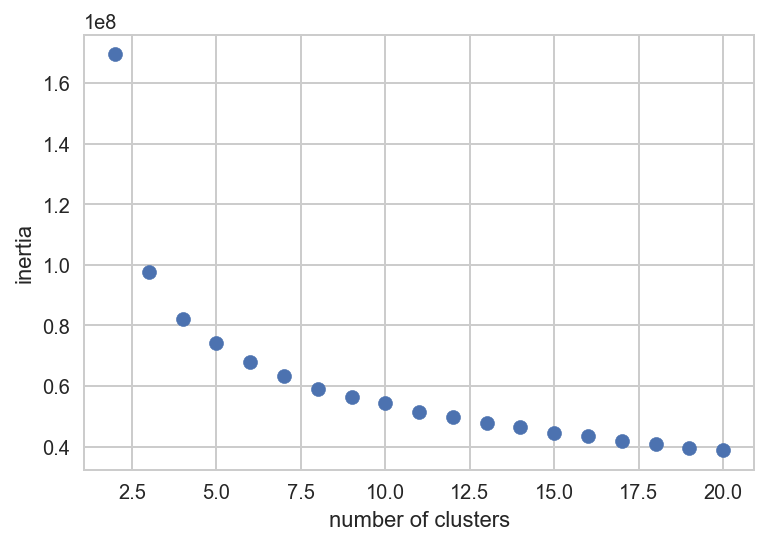

In [411]:
plt.scatter(range(2,21),j_inertia[1:20])
plt.xlabel('number of clusters')
plt.ylabel('inertia')

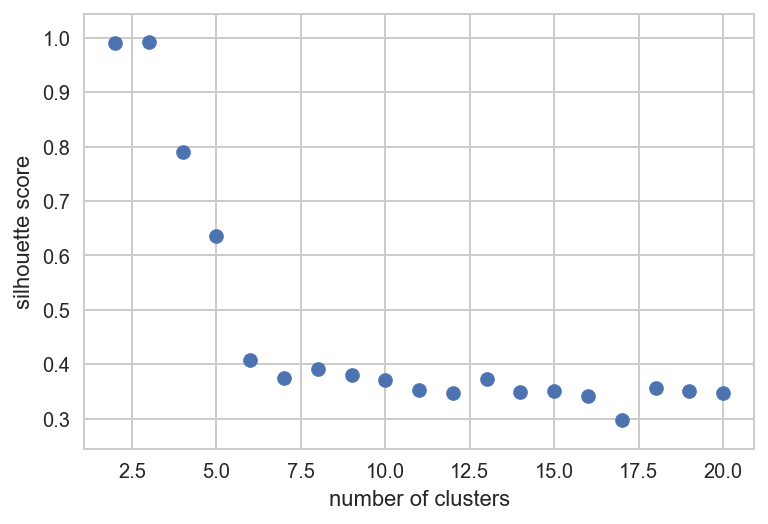

In [414]:
plt.scatter(range(2,21),j_silhouette[0:19])
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')

In [86]:
print(j_inertia[3],j_silhouette[3])

(82185137.722689793, 0.63532891689852233)


In [91]:
j_means[5].cluster_centers_

array([[  2.97567530e+01,   3.91728481e+01,   2.57469559e+01, ...,
          3.40937719e-01,   9.86703989e-02,   5.17844647e-02],
       [  2.88014687e+01,   4.00086098e+01,   2.43728792e+01, ...,
          8.60977463e-02,   4.98860471e-02,   2.79817675e-02],
       [  2.91403829e+01,   3.88860529e+01,   2.48359161e+01, ...,
          2.21513218e-01,   1.01185050e-01,   4.74020055e-02],
       ..., 
       [  2.91567640e+01,   4.03779792e+01,   2.43081571e+01, ...,
          1.60792212e-01,   3.07150050e-01,   1.33266197e-01],
       [  3.03591731e+01,   3.98366925e+01,   2.66806202e+01, ...,
          5.86046512e-01,   2.84237726e-02,   1.13695090e-02],
       [  2.96994189e+01,   3.89482303e+01,   2.60464871e+01, ...,
          2.27680930e-01,   7.92393027e-03,   4.75435816e-03]])

In [99]:
j_means[3].cluster_centers_.shape

(5, 4842)

In [102]:
j_means[3].labels_

array([4, 0, 1, ..., 1, 1, 1], dtype=int32)

In [168]:
label_df=pd.DataFrame(j_means[3].labels_)
label_df.rename(index=str,columns={0:'cluster'},inplace=True)
label_df.head()

,cluster
0,4
1,0
2,1
3,4
4,1


In [210]:
import pickle

In [212]:
pickle.dump( j_means, open( "okc_clusters.p", "wb" ) )



In [181]:
print(okc3.shape,label_df.shape)

((24777, 246), (24777, 1))


In [183]:
label_df.head()


,cluster
0,4
1,0
2,1
3,4
4,1


In [221]:
okc3_ri = okc3.reset_index(drop=True)

In [222]:
okc3_ri=okc3_ri.replace(to_replace=0,value=np.nan)

In [223]:
okc3_ri.loc[:, 'cluster_labels'] = label_df.cluster.tolist()

In [234]:
okc3_ri.cluster_labels=okc3_ri['cluster_labels'].apply(str)
# df[['col2','col3']] = df[['col2','col3']].apply(pd.to_numeric)

In [410]:
okc3_ri.shape

(24777, 247)

In [277]:
okc3_ri.head()

,q34113,q85419,q416235,d_gender,lf_want,d_country,d_age,lf_max_age,lf_for,d_orientation,...,q46856,q15752,q67641,q23293,q21527,q105,q1112,q53965,q32,cluster_labels
0,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,UK,25.0,36.0,For long-term dating,Straight,...,NaN,Extremely important,Very important.,NaN,No,No,Yes,Catch it and put it outside.,I have little or no interest.,4
1,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,Australia,22.0,40.0,"For new friends, long-term dating",Straight,...,Complex,Not at all important,NaN,Wholesome,NaN,No,NaN,Find someone else to deal with it.,I have little or no interest.,0
2,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,UK,29.0,38.0,"For new friends, long-term dating, short-term...",Straight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Everyone,UK,30.0,46.0,"For new friends, long-term dating, short-term...",Bisexual,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men,Netherlands,24.0,30.0,"For new friends, short-term dating",Straight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [237]:
okc3_ri.groupby(['cluster_labels']).count()

,q34113,q85419,q416235,d_gender,lf_want,d_country,d_age,lf_max_age,lf_for,d_orientation,...,q48953,q46856,q15752,q67641,q23293,q21527,q105,q1112,q53965,q32
cluster_labels,,,,,,,,,,,,,,,,,,,,,
0,3392,3392,3392,3392,3392,3392,3392,3392,3392,3392,...,1937,1863,1919,2000,1927,1809,1978,1926,1903,1943
1,9791,9791,9791,9791,9791,9791,9791,9791,9791,9791,...,1786,1718,1657,1746,1688,1772,1789,1872,1758,1750
2,1097,1097,1097,1097,1097,1097,1097,1097,1097,1097,...,383,414,410,396,393,365,369,371,382,406
3,1830,1830,1830,1830,1830,1830,1830,1830,1830,1830,...,706,759,765,743,745,687,674,693,672,802
4,8667,8667,8667,8667,8667,8667,8667,8667,8667,8667,...,4760,4807,4806,4667,4759,4875,4688,4622,4767,4570


In [242]:
okc3_ri2=okc3_ri.groupby(['cluster_labels']).count().reset_index(drop=False)
okc3_ri2

,cluster_labels,q34113,q85419,q416235,d_gender,lf_want,d_country,d_age,lf_max_age,lf_for,...,q48953,q46856,q15752,q67641,q23293,q21527,q105,q1112,q53965,q32
0,0,3392,3392,3392,3392,3392,3392,3392,3392,3392,...,1937,1863,1919,2000,1927,1809,1978,1926,1903,1943
1,1,9791,9791,9791,9791,9791,9791,9791,9791,9791,...,1786,1718,1657,1746,1688,1772,1789,1872,1758,1750
2,2,1097,1097,1097,1097,1097,1097,1097,1097,1097,...,383,414,410,396,393,365,369,371,382,406
3,3,1830,1830,1830,1830,1830,1830,1830,1830,1830,...,706,759,765,743,745,687,674,693,672,802
4,4,8667,8667,8667,8667,8667,8667,8667,8667,8667,...,4760,4807,4806,4667,4759,4875,4688,4622,4767,4570


In [282]:
#15 minutes for 5 clusters
df_list=[]
print('start '+'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
for k in range(0,5):
    print(k,'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
    df=okc3_ri
    #df=df.sort_values(k,axis=1,ascending=False)
    df=df[df['cluster_labels']==str(k)]
  
    
    df=df.apply(mode)
    df_list.append(df)
    
print('end '+'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))

start Timestamp: 2017-08-08 13:24:49
(0, 'Timestamp: 2017-08-08 13:24:49')
(1, 'Timestamp: 2017-08-08 13:25:27')
(2, 'Timestamp: 2017-08-08 13:33:38')
(3, 'Timestamp: 2017-08-08 13:33:45')
(4, 'Timestamp: 2017-08-08 13:34:00')
end Timestamp: 2017-08-08 13:38:00


In [283]:
df_list[0]

q34113                                    ([Never - Get a job], [1502])
q85419                      ([Rosé (such as White Zinfindel).], [2352])
q416235                     ([Can't answer without a subtitle], [2227])
d_gender                                              ([Woman], [3392])
lf_want                                                 ([Men], [2545])
d_country                                                 ([CA], [482])
d_age                                                   ([29.0], [268])
lf_max_age                                              ([35.0], [512])
lf_for                ([For  new friends, long-term dating, short-te...
d_orientation                                      ([Straight], [3193])
d_relationship                                       ([Single], [3379])
lf_location                                         ([Near me], [2749])
lf_min_age                                              ([25.0], [491])
lf_single                                    ([Who are single], 

In [276]:
okc3.head()

,q34113,q85419,q416235,d_gender,lf_want,d_country,d_age,lf_max_age,lf_for,d_orientation,...,q46856,q15752,q67641,q23293,q21527,q105,q1112,q53965,q32,cluster_labels
0,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,UK,25.0,36.0,For long-term dating,Straight,...,0,Extremely important,Very important.,0,No,No,Yes,Catch it and put it outside.,I have little or no interest.,NaN
2,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,Australia,22.0,40.0,"For new friends, long-term dating",Straight,...,Complex,Not at all important,0,Wholesome,0,No,0,Find someone else to deal with it.,I have little or no interest.,NaN
3,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men who like women,UK,29.0,38.0,"For new friends, long-term dating, short-term...",Straight,...,0,0,0,0,0,0,0,0,0,NaN
4,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Everyone,UK,30.0,46.0,"For new friends, long-term dating, short-term...",Bisexual,...,0,0,0,0,0,0,0,0,0,NaN
8,Never - Get a job,Rosé (such as White Zinfindel).,Can't answer without a subtitle,Woman,Men,Netherlands,24.0,30.0,"For new friends, short-term dating",Straight,...,0,0,0,0,0,0,0,0,0,NaN


In [261]:
okc3_ri2[okc3_ri2['cluster_labels']=='0']

,cluster_labels,q34113,q85419,q416235,d_gender,lf_want,d_country,d_age,lf_max_age,lf_for,...,q48953,q46856,q15752,q67641,q23293,q21527,q105,q1112,q53965,q32
0,0,3392,3392,3392,3392,3392,3392,3392,3392,3392,...,1937,1863,1919,2000,1927,1809,1978,1926,1903,1943


In [250]:
#sorted_df = df.sort_values(df.last_valid_index(), axis=1)
okc3_ri_sorted=okc3_ri2.sort_values(0,axis=1,ascending=False)
okc3_ri_sorted

,cluster_labels,d_relationship,q34113,q255,d_astrology_sign,d_religion_type,q64664,q20062,lf_single,lf_min_age,...,q23993,q324,q21527,q13,q47764,q1028,q86366,q60852,q72086,q29384
0,0,3392,3392,3392,3392,3392,3392,3392,3392,3392,...,1813,1812,1809,1795,1784,1776,1751,1740,1739,1581
1,1,9791,9791,0,9790,9790,9791,9791,9791,9791,...,1998,1937,1772,1850,1869,2261,2020,1955,1807,1836
2,2,1097,1097,1097,1097,1097,1097,1097,1097,1097,...,491,492,365,426,350,534,445,402,431,449
3,3,1830,1830,1830,1830,1830,1830,1830,1830,1830,...,873,888,687,776,672,946,832,741,754,814
4,4,8667,8667,8667,8667,8667,8667,8667,8667,8667,...,5363,5304,4875,5125,5043,5549,5374,5150,4919,5090


In [287]:
ok3_ri_sorted=[]
for k in range(0,5):
    df=okc3_ri2
    df=df.sort_values(k,axis=1,ascending=False)
    df=df[df.cluster_labels==str(k)]
    ok3_ri_sorted.append(df)

In [288]:
ok3_ri_sorted[0]

,cluster_labels,d_relationship,q34113,q255,d_astrology_sign,d_religion_type,q64664,q20062,lf_single,lf_min_age,...,q23993,q324,q21527,q13,q47764,q1028,q86366,q60852,q72086,q29384
0,0,3392,3392,3392,3392,3392,3392,3392,3392,3392,...,1813,1812,1809,1795,1784,1776,1751,1740,1739,1581


In [289]:
type(df_list[0])

pandas.core.series.Series

In [291]:
pd.DataFrame(df_list[0]).T

,q34113,q85419,q416235,d_gender,lf_want,d_country,d_age,lf_max_age,lf_for,d_orientation,...,q46856,q15752,q67641,q23293,q21527,q105,q1112,q53965,q32,cluster_labels
0,"([Never - Get a job], [1502])","([Rosé (such as White Zinfindel).], [2352])","([Can't answer without a subtitle], [2227])","([Woman], [3392])","([Men], [2545])","([CA], [482])","([29.0], [268])","([35.0], [512])","([For new friends, long-term dating, short-te...","([Straight], [3193])",...,"([Complex], [940])","([Very important], [860])","([Very important.], [1258])","([Wholesome], [1063])","([No], [1750])","([No], [1571])","([No], [1079])","([Kill it.], [792])","([I have little or no interest.], [1761])","([0], [3392])"


In [296]:
pd.concat((pd.DataFrame(df_list[0]).T,ok3_ri_sorted[0]),axis=0).reset_index()

,index,cluster_labels,d_age,d_astrology_seriosity,d_astrology_sign,d_bodytype,d_country,d_drinks,d_drugs,d_education_phase,...,q86366,q8672,q87,q8865,q9379,q9668,q9688,q979,q997,race
0,0,"([0], [3392])","([29.0], [268])","([and it's fun to think about], [1166])","([-], [527])","([Average], [835])","([CA], [482])","([Socially], [2011])","([Never], [3173])","([Graduated from], [2057])",...,"([Maybe, depending upon the circumstances.], [...","([Why], [1415])","([Yes], [2000])","([Yes, I have a fulltime job], [1477])","([No], [1342])","([Balanced], [1353])","([No], [2537])","([1-2], [1481])","([Both], [1288])","([White], [1879])"
1,0,0,3392,2056,3392,2918,3392,3174,3208,2743,...,1751,3002,2855,1970,1967,2018,3239,2450,3236,3092


In [299]:
df_stacked=[]
for k in range(5):
    x=pd.concat((pd.DataFrame(df_list[k]).T,ok3_ri_sorted[k]),axis=0).reset_index()
    x=x.sort_values(1,axis=1,ascending=False)
    df_stacked.append(x)

In [300]:
df_stacked[0]

,cluster_labels,q255,d_orientation,q85419,q34113,q416235,lf_want,lf_single,lf_min_age,lf_max_age,...,q324,q21527,q13,q47764,q1028,q86366,q60852,q72086,q29384,index
0,"([0], [3392])","([89547.0], [3097])","([Straight], [3193])","([Rosé (such as White Zinfindel).], [2352])","([Never - Get a job], [1502])","([Can't answer without a subtitle], [2227])","([Men], [2545])","([Who are single], [3392])","([25.0], [491])","([35.0], [512])",...,"([I disagree.], [1388])","([No], [1750])","([No], [1257])","([Yes.], [1620])","([I enjoy both equally], [1235])","([Maybe, depending upon the circumstances.], [...","([Yes], [1528])","([Yes.], [1037])","([Yes.], [873])",0
1,0,3392,3392,3392,3392,3392,3392,3392,3392,3392,...,1812,1809,1795,1784,1776,1751,1740,1739,1581,0


In [305]:
questions2=questions[['q','text']]
questions3=questions2.T
questions3

,0,1,2,3,4,5,6,7,8,9,...,2610,2611,2612,2613,2614,2615,2616,2617,2618,2619
q,q2,q11,q12,q13,q14,q16,q17,q18,q20,q21,...,d_offspring_desires,d_city,d_education_type,d_religion_seriosity,lf_want,lf_max_age,lf_for,lf_location,lf_min_age,lf_single
text,Breast implants?,How does the idea of being slapped hard in the...,Divide your age by 2. Have you had sex with a...,Is a girl who's slept with 100 guys a bad person?,Is a guy who's slept with 100 girls a bad person?,Should sex with someone 16 years old be a jail...,Would you date someone just for the sex?,Do you have experience being in a slave/master...,"BDSM: Without looking it up, do you know exact...",Do you enjoy meaningless sex?,...,Children preferences,City,Education type,Religion seriousness,Type of match,Max age of match,Looking for match,Location of match,Min age of match,Status of match


In [312]:
b[0]

'q2'

In [326]:
a=questions3.columns
b=questions3.iloc[0]
questions3=questions3.rename(index=str,columns=lambda x:b[x])
questions3

,q2,q11,q12,q13,q14,q16,q17,q18,q20,q21,...,d_offspring_desires,d_city,d_education_type,d_religion_seriosity,lf_want,lf_max_age,lf_for,lf_location,lf_min_age,lf_single
q,q2,q11,q12,q13,q14,q16,q17,q18,q20,q21,...,d_offspring_desires,d_city,d_education_type,d_religion_seriosity,lf_want,lf_max_age,lf_for,lf_location,lf_min_age,lf_single
text,Breast implants?,How does the idea of being slapped hard in the...,Divide your age by 2. Have you had sex with a...,Is a girl who's slept with 100 guys a bad person?,Is a guy who's slept with 100 girls a bad person?,Should sex with someone 16 years old be a jail...,Would you date someone just for the sex?,Do you have experience being in a slave/master...,"BDSM: Without looking it up, do you know exact...",Do you enjoy meaningless sex?,...,Children preferences,City,Education type,Religion seriousness,Type of match,Max age of match,Looking for match,Location of match,Min age of match,Status of match


In [391]:
profile=[]
for k in range(0,5):
    a=pd.concat((df_stacked[k],questions3),axis=0)
    a=a.T
    a2=a[pd.notnull(a[1])]
    
    a2=a2[['q','text',0,1,]]
    a2=a2.rename(index=str,columns={1:'total_response_count', 0:'answer_mode_and_count'})
    a2=a2.sort_values(['total_response_count','q'],ascending=False)
    a2=a2.drop(['q'],1)
    profile.append(a2)

    

In [417]:
profile[1]

,text,answer_mode_and_count,total_response_count
cluster_labels,NaN,"([1], [9791])",1
q85419,Which type of wine would you prefer to drink o...,"([Rosé (such as White Zinfindel).], [8968])",9791
q64664,Do you think it is okay to open old graves to ...,"([I don't really care.], [9750])",9791
q416235,Do you like watching foreign movies with subti...,"([Can't answer without a subtitle], [8847])",9791
q34113,How do you feel about government-subsidized fo...,"([Never - Get a job], [8078])",9791
q20062,While in the middle of the best lovemaking of ...,"([The best? Maybe...], [9380])",9791
lf_want,Type of match,"([Men], [5707])",9791
lf_single,Status of match,"([Who are single], [9791])",9791
lf_min_age,Min age of match,"([25.0], [1206])",9791
lf_max_age,Max age of match,"([35.0], [1212])",9791


In [58]:
from kmodes import kmodes


In [179]:
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
km = kmodes.KModes(n_clusters=5)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
clusters_km = km.fit_predict(okc3_dummies)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))

Timestamp: 2017-08-08 00:33:50
Timestamp: 2017-08-08 00:33:50
Timestamp: 2017-08-08 08:51:10


In [ ]:
from scipy.spatial.distance import pdist
Y=pdist(clusters,'euclidean')
Y.shape

In [ ]:
Y.shape

In [ ]:
clusters.shape

In [ ]:
clusters.shape[0]

In [ ]:
clusters[0:]

In [ ]:
for j in range(20):
    print (clusters[0:][j])

In [ ]:
v=[[1,2],[30,40],[50,60],[700,800]]
w=[[5,6],[7,8],[30,40]]
print(pdist(v,'euclidean'))
print(pdist(w,'euclidean'))
print(pdist([[7,8],[30,40]],'euclidean'))            

In [ ]:
n=0
m=0
for k in clusters:
    n+=1
    for j in clusters:
        m+=1
        print((n,m),(pdist((k,j),'euclidean')))
    m=0

In [ ]:
d=clusters[0]-clusters[1]
    


In [ ]:

def plot_dendrogram(df):
    
    # Data prep
    X = df.as_matrix(columns=None)
    Z = linkage(X, 'ward')
    
    # plotting
    plt.figure(figsize = (12,6))
    plt.title('Dendrogram')
    plt.xlabel('Index Numbers')
    plt.ylabel('Distance')
    dendrogram(
        Z,
        leaf_rotation=0.,  
        leaf_font_size=20.,
    )
    
    plt.show()
    return Z

In [ ]:
import datetime
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
Z1=plot_dendrogram(okc3_dummies)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))

In [31]:
import hdbscan
import datetime


In [ ]:
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
cluster_labels = clusterer.fit_predict(okc3_dummies)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))

Timestamp: 2017-08-07 15:49:14
Timestamp: 2017-08-07 15:49:14
